In [1]:
from tensorflow import keras
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from sklearn import svm
from sklearn.metrics import accuracy_score
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import normalize
import sklearn.neighbors as knn
import and_logic_generator as and_gen
import utils
import applicability_domain as ad
import adversarial_generator as adversarial

# reload modules every 2 seconds
%load_ext autoreload
%autoreload 2


In [2]:
# Repeatable seed
random_state = 2**12
np.random.seed(seed=random_state)


In [3]:
n = 2000
x, y = and_gen.generate_logistic_samples(1000, random_state=random_state)
x = x - 0.5
x, x_norms = normalize(x, norm='l2', axis=0, return_norm=True)
print(x_norms)


[8.56014969 8.90144364]


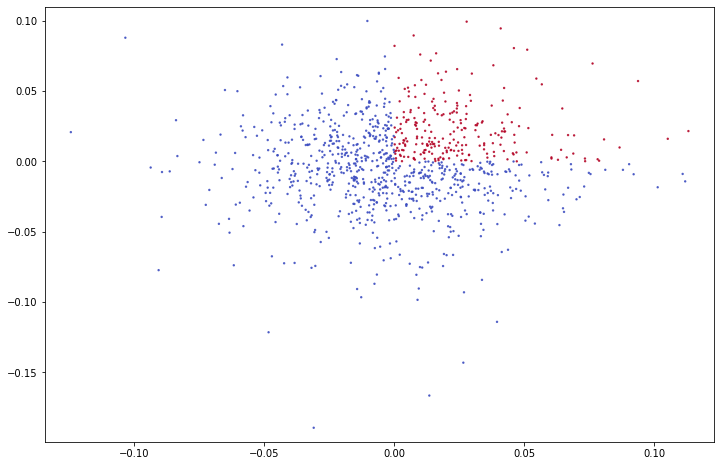

In [4]:
# Increasing the size of the plots
figsize = np.array(plt.rcParams["figure.figsize"]) * 2

x_max = np.amax(x, axis=0) + 0.01
x_min = np.amin(x, axis=0) - 0.01

plt.figure(figsize=figsize.tolist())
plt.scatter(
    x[:, 0], x[:, 1], marker='.', c=y, alpha=0.8, cmap='coolwarm',
    s=8, edgecolor='face')
plt.grid(False)
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()


In [5]:
# 80:20 split on training and test sets
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4)


In [6]:
# Prediction model
# This model does NOT aware of adversarial examples.
# SVM
gamma = 'scale'
C = 100

model_svm = svm.SVC(
    kernel='rbf', random_state=random_state, gamma=gamma, C=C)
model_svm.fit(x_train, y_train)

pred_train = model_svm.predict(x_train)
score_train = accuracy_score(y_train, pred_train)

pred_test = model_svm.predict(x_test)
score_test = accuracy_score(y_test, pred_test)

print(f'With gamma = {gamma} and C = {C}')
print(f'Accuracy on train set = {score_train*100:.4f}%')
print(f'Accuracy on test set  = {score_test*100:.4f}%')


With gamma = scale and C = 100
Accuracy on train set = 98.6667%
Accuracy on test set  = 98.5000%


In [7]:
# Sanity check
x_basis, y_basis = and_gen.get_basic_set(shift=[[-0.5, -0.5]], norms=[x_norms])
utils.run_basic_test(x_basis, y_basis, model_svm)


Pass basic test


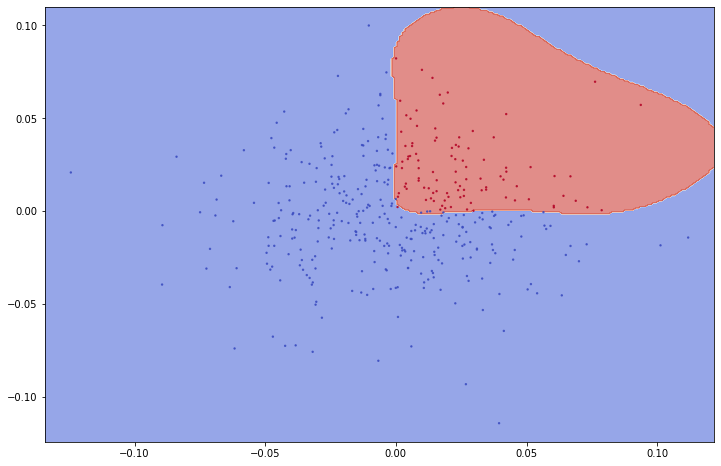

In [8]:
h = .001
# by symmetry x and y axis should be in same range
x_max = np.amax(x_test, axis=0) + 0.01
x_min = np.amin(x_test, axis=0) - 0.01

xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_test[:, 0], x_test[:, 1], c=y_test, marker='.', alpha=0.8,
    cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()


In [9]:
model_svm.get_params()


{'C': 100,
 'break_ties': False,
 'cache_size': 200,
 'class_weight': None,
 'coef0': 0.0,
 'decision_function_shape': 'ovr',
 'degree': 3,
 'gamma': 'scale',
 'kernel': 'rbf',
 'max_iter': -1,
 'probability': False,
 'random_state': 4096,
 'shrinking': True,
 'tol': 0.001,
 'verbose': False}

In [10]:
# Creating adversarial examples
# Grey-box scenario, the attacker has the access on the training set
ind_train_c1 = np.where(y_train == 1)
x_train_c1 = x_train[ind_train_c1]
y_train_c1 = np.ones(len(x_train_c1))
mu_train_c1 = np.mean(x_train_c1, axis=0)

ind_train_c0 = np.where(y_train == 0)
x_train_c0 = x_train[ind_train_c0]
y_train_c0 = np.zeros(len(x_train_c0))
mu_train_c0 = np.mean(x_train_c0, axis=0)

print(f'Positive mean = [{mu_train_c1[0]:.4f}, {mu_train_c1[1]:.4f}]')
print(f'Negative mean = [{mu_train_c0[0]:.4f}, {mu_train_c0[1]:.4f}]')


Positive mean = [0.0248, 0.0226]
Negative mean = [-0.0057, -0.0090]


In [11]:
# Generating Adversarial Examples from test set
# This implementation uses multiple iterations to update x, until all of them
# match the target classes.
epsilon = 0.0006

adversarial_examples = np.copy(x_test)  # make a clone
pred = pred_test
# Aimed to generate labels which completely opposite to the true labels, 
# not the prediction from SVM.
targets = and_gen.get_not_y(y_test)

epoch = 1
while np.array_equal(pred, targets) == False:
    adversarial_examples = adversarial.moving_mean(
        x=adversarial_examples,
        y=pred,
        targets=targets,
        means={0: mu_train_c0, 1: mu_train_c1},
        epsilon=epsilon,
        verbose=0,
        epoch=epoch)
    pred = model_svm.predict(adversarial_examples)
    epoch += 1

print(f'Completed after {epoch} epoch.')


Completed after 208 epoch.


In [12]:
# Results
original_pred = model_svm.predict(x_test)
pred_ae = model_svm.predict(adversarial_examples)
y_ae = and_gen.get_y(adversarial_examples)

matches = np.equal(y_ae, pred_ae)
ind_misclassified = np.where(matches == False)[0]

# Print all misclassified samples
# for i in ind_misclassified:
#     print(
#         f'from [{x_test[i][0]: .4f}, {x_test[i][1]: .4f}] = {original_pred[i]}'
#         + f' to [{adversarial_examples[i][0]: .4f}, '
#         + f'{adversarial_examples[i][1]: .4f}] = {pred_ae[i]};'
#         + f' True y = {y_ae[i]}')

y_miss = y_ae[ind_misclassified]
print(f'Misclassified positive = {len(y_miss[y_miss==1])}')
print(f'Misclassified negative = {len(y_miss[y_miss==0])}')

count = len(matches[matches==False])
print(f'\nFound {len(ind_misclassified)} Adversarial Examples out of ' 
    + f'{len(y_ae)}. {len(ind_misclassified) / len(y_ae) * 100.0:.4f}% '
    + 'successful rate')


Misclassified positive = 0
Misclassified negative = 302

Found 302 Adversarial Examples out of 400. 75.5000% successful rate


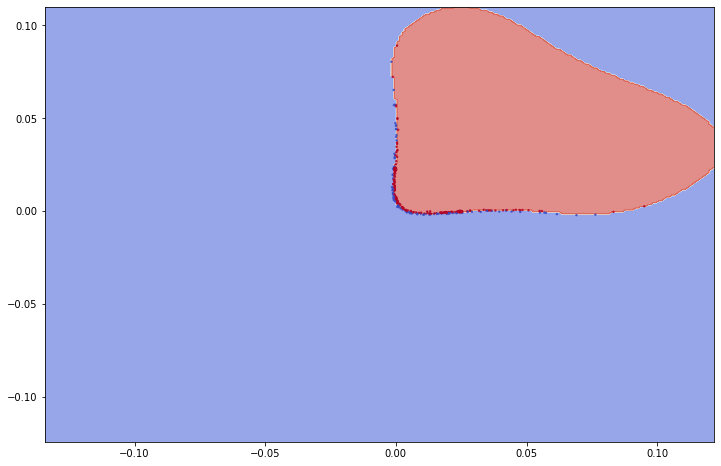

In [13]:
xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    adversarial_examples[:, 0], adversarial_examples[:, 1], 
    c=pred_ae, marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()


In [14]:
# Apply Applicability Domain
# Use the adversarial examples from previous step
x_ae = adversarial_examples
y_ae = and_gen.get_y(x_ae)
pred_ae = pred_ae = model_svm.predict(x_ae)
score = accuracy_score(y_ae, pred_ae)

print(f'Accuracy on the given set = {score*100:.4f}%')

# Applicability Domain
# Stage 1 - Applicability
print('\n---------- Applicability ---------------')
x_passed_s1, ind_passed_s1 = ad.check_applicability(x_ae, x_train, y_train)
pred_passed_s1 = pred_ae[ind_passed_s1]

# Print
pass_rate = utils.get_rate(x_passed_s1, x_ae)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Applicability Domain:')
# utils.print_blocked_samples(x_ae, ind_passed_s1)


Accuracy on the given set = 24.5000%

---------- Applicability ---------------
Pass rate = 100.0000%


In [15]:
# Stage 2 - Reliability
print('\n---------- Reliability -----------------')
# Parameters:
k = 9
zeta = 1.2

# Creating kNN models for each class
ind_train_c1 = np.where(y_train == 1)
model_knn_c1 = utils.unimodal_knn(x_train[ind_train_c1], k)

ind_train_c0 = np.where(y_train == 0)
model_knn_c0 = utils.unimodal_knn(x_train[ind_train_c0], k)

# Computing mean, standard deviation and threshold
mu_c1, sd_c1 = utils.get_distance_info(
    model_knn_c1, x_train[ind_train_c1], k, seen_in_train_set=True)
threshold_c1 = ad.get_reliability_threshold(mu_c1, sd_c1, zeta)

mu_c0, sd_c0 = utils.get_distance_info(
    model_knn_c0, x_train[ind_train_c0], k, seen_in_train_set=True)
threshold_c0 = ad.get_reliability_threshold(mu_c0, sd_c0, zeta)

x_passed_s2, ind_passed_s2 = ad.check_reliability(
    x_passed_s1,
    predictions=pred_passed_s1,
    models=[model_knn_c0, model_knn_c1],
    dist_thresholds=[threshold_c0, threshold_c1],
    classes=[0, 1],
    verbose=0
)
pred_passed_s2 = pred_passed_s1[ind_passed_s2]

# Print
print('Distance of c1 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c1))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c1))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c1))

print('Distance of c0 in training set:')
print('{:18s} = {:.4f}'.format('Mean', mu_c0))
print('{:18s} = {:.4f}'.format('Standard deviation', sd_c0))
print('{:18s} = {:.4f}\n'.format('Threshold', threshold_c0))

pass_rate = utils.get_rate(x_passed_s2, x_passed_s1)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Reliability Domain:')
# utils.print_blocked_samples(x_passed_s1, ind_passed_s2)



---------- Reliability -----------------
Distance of c1 in training set:
Mean               = 0.0081
Standard deviation = 0.0067
Threshold          = 0.0161

Distance of c0 in training set:
Mean               = 0.0074
Standard deviation = 0.0083
Threshold          = 0.0174

Pass rate = 98.7500%


In [16]:
# Stage 3 - Decidability
print('\n---------- Decidability ----------------')
model_knn = knn.KNeighborsClassifier(
    n_neighbors=k, n_jobs=-1, weights='distance')
model_knn.fit(x_train, y_train)

x_passed_s3, ind_passed_s3 = ad.check_decidability(
    x_passed_s2, pred_passed_s2, model_knn)


# Print
pass_rate = utils.get_rate(x_passed_s3, x_passed_s2)
print(f'Pass rate = {pass_rate * 100:.4f}%')
# print('Blocked by Decidability Domain:')
# utils.print_blocked_samples(x_passed_s2, ind_passed_s3)



---------- Decidability ----------------
Pass rate = 52.1519%


In [17]:
# Results
score = accuracy_score(y_ae, pred_ae)
print(f'Accuracy before AD = {score*100:.4f}%')
print()

pass_rate = utils.get_rate(x_passed_s3, x_ae)
y_passed = and_gen.get_y(x_passed_s3)
pred_after_ad = model_svm.predict(x_passed_s3)
score = accuracy_score(y_passed, pred_after_ad)
matches = np.equal(y_passed, pred_after_ad)
ind_misclassified = np.where(matches == False)[0]

print(f'\nOverall pass rate = {pass_rate * 100:.4f}%')
print(f'Accuracy after AD = {score*100:.4f}%')
print(f'{len(x_passed_s3)} out of {len(x_ae)}')
print(f'Misclassified = {len(ind_misclassified)}')
y_miss = y_passed[ind_misclassified]
print(f'Misclassified positive = {len(y_miss[y_miss==1])}')
print(f'Misclassified negative = {len(y_miss[y_miss==0])}')
print()

# for i in ind_misclassified:
#     print(
#         f'[{adversarial_examples[i][0]: .4f}, ' 
#         + f'{adversarial_examples[i][1]: .4f}] = {pred_after_ad[i]};'
#         + f' True y = {y_passed[i]}')


Accuracy before AD = 24.5000%


Overall pass rate = 51.5000%
Accuracy after AD = 33.0097%
206 out of 400
Misclassified = 138
Misclassified positive = 0
Misclassified negative = 138



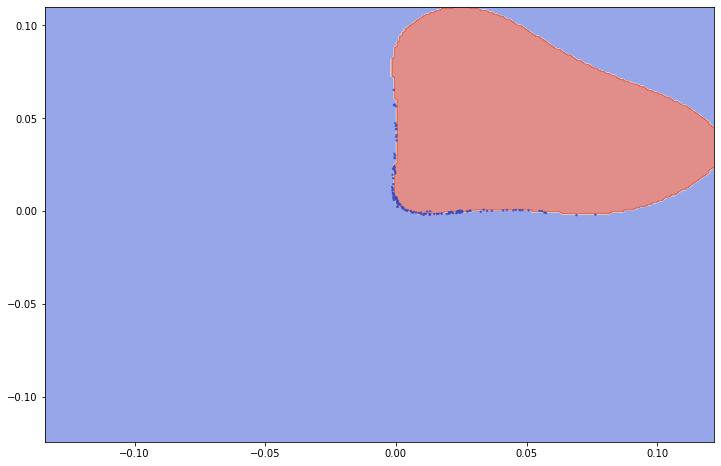

In [18]:
xx, yy = np.meshgrid(
    np.arange(x_min[0], x_max[0], h), 
    np.arange(x_min[1], x_max[1], h))
Z = model_svm.predict(np.c_[xx.ravel(), yy.ravel()])
Z = Z.reshape(xx.shape)

plt.figure(figsize=figsize.tolist())
plt.contourf(xx, yy, Z, cmap='coolwarm', alpha=0.6)
plt.scatter(
    x_passed_s3[:, 0], x_passed_s3[:, 1], 
    c=y_passed, marker='.', alpha=0.8, cmap='coolwarm', s=8, edgecolor='face')
plt.xlim(x_min[0], x_max[0])
plt.ylim(x_min[1], x_max[1])
plt.show()

